# Imports

In [ ]:
!pip install pywaffle
from pywaffle import Waffle
from google.colab import drive
import pandas as pd
from os import listdir
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.signal as signal

matplotlib.rc('figure', figsize=(9, 7))
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 18.1 MB/s eta 0:00:00
Mounted at /content/drive


# Datasets + data cleaning

In [ ]:
country_codes = ['AUS',	'BRA',	'BWA',	'CHN',	'COD',	'DEU',	'GBR',	'IND',	'NER',	'NOR',	'ROU',	'USA']
country_names = ['Australia', 'Brazil', 'Botswana', 'China', 'Democratic Republic of Congo', 'Germany', 'United Kingdom', 'India', 'Norway', 'Niger', 'Romania', 'United States']
country_colors = {'Australia' : '#9B1D20',
                  'Botswana' : '#635D5C',
                  'Brazil' : '#3D2B3D',
                  'China' : '#CBEFB6',
                  'Democratic Republic of Congo' : '#E0AFA0',
                  'Germany' : '#587b7f',
                  'India' : '#0C4767',
                  'Niger' : '#14248A',
                  'Norway' : '#D4C2FC',
                  'Romania' : '#FFC857',
                  'United Kingdom' : '#C7EBF0',
                  'United States' : '#566E3D'
                  }

In [ ]:
data_dir = "/content/drive/My Drive/Master/Anul I/Sem II/BDV/BDV shared/data/"
co2_countries_file = data_dir + 'co2-countries-1960-present.csv'
co2_1750_present_file = data_dir + 'co2-1750-present.csv'
burned_area_file = data_dir + 'burned_area_full_dataset_2002-2019.csv'
annual_forest_change_file = data_dir + 'annual-change-forest-area.csv'

temp_and_precipitations_dir = data_dir + 'temp_and_precipitations/'


In [ ]:
def get_temperatures_and_precipitations():
  onlyfiles = [f for f in listdir(temp_and_precipitations_dir)]
  onlyfiles.sort()

  temperatures_all_countries = {}
  precipitations_all_countries = {}

  for file_name in onlyfiles:
    country = file_name.split('_')[-1].split('.')[0]
    dataset_type = file_name.split('_')[0]

    key_name = country  # ex: AUS
    df_content = pd.read_csv(temp_and_precipitations_dir + file_name)

    # this handles the bad formatting the data comes in
    df_content = df_content['Variable:'].reset_index()
    column_names = df_content.iloc[0].values
    df_content = df_content.rename(columns=dict(zip(df_content.columns, column_names)))
    df_content = df_content.drop(0)

    if dataset_type == 'pr':
      precipitations_all_countries[key_name] = df_content
    else:
      temperatures_all_countries[key_name] = df_content
  return [temperatures_all_countries, precipitations_all_countries]

def get_dataframes():
  emissions_1960 = pd.read_csv(co2_countries_file, sep=";")
  emissions_1750 = pd.read_csv(co2_1750_present_file, sep=",")
  burned_area = pd.read_csv(burned_area_file, sep=",")
  forrest_change = pd.read_csv(annual_forest_change_file, sep=",")
  temperatures, precipitations = get_temperatures_and_precipitations()
  return [temperatures, precipitations, forrest_change, emissions_1960, burned_area, emissions_1750]

def get_temperatures_for_countries():
  average_yearly_temperatures = pd.DataFrame()
  first_run = True

  for key in temperatures.keys():
    current_df = temperatures[key]
    if first_run: # add year column
      year_column = current_df.iloc[:, 0]
      condition = year_column >= 1990
      average_yearly_temperatures['Year'] = year_column
      first_run = False

    country_column = current_df.columns[1]
    condition = year_column >= 1990
    temperatures_for_country = current_df.loc[condition, [country_column]]

    average_yearly_temperatures[key] = temperatures_for_country

  year_column = average_yearly_temperatures.iloc[:, 0]
  condition = year_column < 1990
  average_yearly_temperatures = average_yearly_temperatures.drop(average_yearly_temperatures[condition].index)

  return average_yearly_temperatures

def get_precipitations_for_countries():
  average_yearly_precipitations = pd.DataFrame()
  first_run = True

  for key in precipitations.keys():
    current_df = precipitations[key]
    if first_run: # add year column
      year_column = current_df.iloc[:, 0]
      condition = year_column >= 1990
      average_yearly_precipitations['Year'] = year_column
      first_run = False

    country_column = current_df.columns[1]
    condition = year_column >= 1990
    precipitations_for_country = current_df.loc[condition, [country_column]]

    average_yearly_precipitations[key] = precipitations_for_country

  year_column = average_yearly_precipitations.iloc[:, 0]
  condition = year_column < 1990
  average_yearly_precipitations = average_yearly_precipitations.drop(average_yearly_precipitations[condition].index)

  return average_yearly_precipitations

def get_relevant_forrest_change():
  forrest_df = forrest_change
  condition = forrest_df['Code'].astype(str).isin(country_codes)
  relevant_df = forrest_df.loc[condition]

  return relevant_df



In [ ]:
def get_relevant_burned_area():
  burned_area_df = burned_area
  all_different_countries = burned_area_df['Country'].astype(str)
  condition = burned_area_df['GID_0'].astype(str).isin(country_codes) #burned_area_df['Country'].astype(str).isin(country_names)
  relevant_df = burned_area_df.loc[condition]
  return relevant_df

def get_burned_area_dfs_by_country(relevant_burned_area):
  burned_area_dict_df = {}
  for country in country_names:
    country_burned_area = relevant_burned_area.loc[relevant_burned_area['Country'] == country]
    country_burned_by_year, country_burned_by_season = get_burned_area_grouped_by_year_and_season(country_burned_area)

    burned_area_dict_df[country] = {'Year' : country_burned_by_year, 'Season': country_burned_by_season}

  return burned_area_dict_df
def get_burned_area_by_season(df):
  # 2002 Summer   123
  # 2002 Spring   456
  # 2002 Autumn   789
  # 2002 Winter   112

  burned_area_by_season = pd.DataFrame()
  years = list()
  seasons = list()
  burned_area = list()

  grouped_years = df.groupby('Year')
  for year, group in grouped_years:
    grouped_seasons = group.groupby("Season")
    for season, season_group in grouped_seasons:
      years.append(year)
      seasons.append(season)
      total_hectares_burned_this_season = season_group['Total hectares burned'].sum()
      burned_area.append(total_hectares_burned_this_season)

  burned_area_by_season['Year'] = years
  burned_area_by_season['Season'] = seasons
  burned_area_by_season['Burned Area'] = burned_area

  return burned_area_by_season

def get_burned_area_by_year(df):
  burned_area_by_year = pd.DataFrame()
  years = list()
  burned_area = list()

  grouped = df.groupby('Year')
  for year, group in grouped:
    total_hectares_burned_this_year = group['Total hectares burned'].sum()
    group['Burned per year total'] = total_hectares_burned_this_year
    years.append(year)
    burned_area.append(total_hectares_burned_this_year)

  burned_area_by_year['Year'] = years
  burned_area_by_year['Burned Area'] = burned_area

  return burned_area_by_year

def get_burned_area_grouped_by_year_and_season(df):
  surface_burned = df[['Cropland_BA_hectares', 'Forest_BA_hectares', 'Grass_and_Shrubland_BA_hectares', 'Wetlands_BA_hectares', 'Settlement_BA_hectares', 'Other_BA_hectares']].sum(axis=1)
  df['Total hectares burned'] = surface_burned

  # drop these, no longer needed - we sum their values in a "total hectares burned"
  columns_to_drop = ['GID_1', 'Cropland_BA_hectares', 'Forest_BA_hectares', 'Grass_and_Shrubland_BA_hectares', 'Wetlands_BA_hectares', 'Settlement_BA_hectares', 'Other_BA_hectares']
  df = df.drop(columns=columns_to_drop)

  # group by season instead of month
  season_mapping = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                  5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                  9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

  df['Season'] = df['Month'].map(season_mapping)

  # drop month and region as well
  columns_to_drop = ['Month', 'Region']
  df = df.drop(columns=columns_to_drop)

  total_hectares_burned_for_country = df['Total hectares burned'].sum()

  burned_area_by_season =get_burned_area_by_season(df)
  burned_area_by_year = get_burned_area_by_year(df)

  return [burned_area_by_year, burned_area_by_season]

In [ ]:
def get_emissions_since_1990():
  co2_since_1990 = emissions_1960['Territorial emissions in MtCO₂']
  co2_df = co2_since_1990.reset_index()
  actual_column_names = co2_df.iloc[0]
  actual_column_names[0] = 'Year'
  co2_df = co2_df.rename(columns=actual_column_names)

  # need to drop these
  co2_df = co2_df.drop(co2_df.index[0])
  co2_df = co2_df.drop(co2_df.index[62])
  co2_df = co2_df.drop(co2_df.index[-1])

  condition = co2_df['Year'].astype(int) > 1989
  co2_since_1990 = co2_df.loc[condition]

  return co2_since_1990

In [ ]:
def get_clean_data():
  average_yearly_temperatures = get_temperatures_for_countries()
  average_yearly_precipitations = get_precipitations_for_countries()
  relevant_forrest_change = get_relevant_forrest_change()
  relevant_burned_area = get_relevant_burned_area()
  burned_area_by_year_or_season = get_burned_area_dfs_by_country(relevant_burned_area)
  emissions_1990 = get_emissions_since_1990()

  return [average_yearly_temperatures, average_yearly_precipitations, relevant_forrest_change, burned_area_by_year_or_season, emissions_1990]

In [ ]:
def get_transposed(some_df):
  df = some_df

  df.set_index('Country Name', inplace=True)
  df = df.transpose()
  df.reset_index(inplace=True)
  df.rename(columns={'index':'Year'}, inplace=True)
  df.rename(columns={'Congo, Dem. Rep.':'Democratic Republic of Congo'}, inplace=True)

  df = df.drop([31, 32])

  return df


def get_population_data():
  population_data = pd.read_csv(data_dir + 'population_by_year_1990_2020.csv', sep=";")

  temp_df = population_data

  # drop useless rows
  temp_df = temp_df.drop([0, 1, 2])

  # rename columns to good values
  new_column_names = temp_df.iloc[0]
  temp_df = temp_df.rename(columns=new_column_names)
  # remove useless row
  temp_df = temp_df.drop([3])

  # remove years not needed
  columns_to_drop = temp_df.columns[2:34]
  temp_df = temp_df.drop(columns=columns_to_drop)
  columns_to_drop = temp_df.columns[-3:-1]
  temp_df = temp_df.drop(columns=columns_to_drop)

  final_df = temp_df
  final_df = final_df.drop(columns=['Country Name', 'Country Code']).apply(pd.to_numeric, errors='coerce')
  final_df['Country Name'] = temp_df['Country Name']
  final_df['Country Code'] = temp_df['Country Code']

  transposed_df = get_transposed(final_df)
  transposed_df = transposed_df.applymap('{:.0f}'.format)

  return transposed_df

# Data inspection

In [ ]:
temperatures, precipitations, forrest_change, emissions_1960, burned_area, emissions_1750 = get_dataframes()

##Temperatures

In [ ]:
temperatures['AUS'].head(5)

,NaN,Australia,Australian Capital Territory,Coral Sea Islands Territory,New South Wales,Northern Territory,Other Territories,Queensland,South Australia,Tasmania,Victoria
1,1901.0,21.53,11.29,NaN,17.55,24.85,17.15,23.14,18.93,9.89,14.11
2,1902.0,21.53,11.25,NaN,17.54,25.10,17.09,23.24,18.95,9.76,14.05
3,1903.0,21.18,10.80,NaN,17.03,24.63,16.71,22.85,18.36,9.76,13.68
4,1904.0,21.11,10.73,NaN,16.93,24.20,16.55,22.71,18.37,9.79,13.71
5,1905.0,21.19,10.44,NaN,16.69,24.85,16.35,22.74,18.27,9.64,13.40


In [ ]:
average_yearly_temperatures = get_temperatures_for_countries()

In [ ]:
average_yearly_temperatures.head(5)

,Year,AUS,BRA,BWA,CHN,COD,DEU,GBR,IND,NER,NOR,ROU,USA
90,1990,22.04,25.12,21.80,7.48,24.34,9.81,9.54,24.38,27.95,2.86,10.05,9.36
91,1991,22.20,25.05,21.58,7.07,24.13,8.73,8.70,24.47,27.76,2.00,8.95,9.34
92,1992,21.68,24.91,22.43,6.81,24.07,9.64,8.86,24.35,27.06,2.32,9.49,8.89
93,1993,21.91,25.02,21.97,6.87,24.03,8.76,8.48,24.59,27.67,1.34,8.97,8.71
94,1994,21.84,25.14,21.46,7.47,24.06,9.94,9.05,24.46,27.37,1.42,10.61,9.23


In [ ]:
average_yearly_temperatures['Year'] = average_yearly_temperatures['Year'].astype(int)

In [ ]:
s = pd.Series(average_yearly_temperatures.columns[1:])
s.describe()

count      12
unique     12
top       AUS
freq        1
dtype: object

##Precipitations

In [ ]:
average_yearly_precipitations = get_precipitations_for_countries()

In [ ]:
average_yearly_precipitations.head(5)

,Year,AUS,BRA,BWA,CHN,COD,DEU,GBR,IND,NER,NOR,ROU,USA
90,1990.0,435.48,1676.21,292.46,640.11,1534.26,734.15,1213.00,1242.16,130.21,1231.52,485.22,769.34
91,1991.0,477.68,1732.52,457.16,587.10,1488.23,604.17,1021.93,1033.18,184.94,1043.70,717.67,758.04
92,1992.0,466.72,1712.63,229.31,580.49,1433.62,735.03,1220.97,965.08,178.06,1233.26,519.92,746.13
93,1993.0,498.84,1693.30,311.95,635.62,1460.26,793.47,1190.58,1066.93,150.65,1023.28,588.07,772.81
94,1994.0,355.25,1849.90,295.00,621.75,1438.30,789.20,1243.43,1156.27,230.99,1030.44,537.44,728.78


##Forrest change

In [ ]:
relevant_forrest_change = get_relevant_forrest_change()

In [ ]:
relevant_forrest_change.head(5)

,Entity,Code,Year,Annual net change in forest area
12,Australia,AUS,1990,-206810.0
13,Australia,AUS,2000,-226800.0
14,Australia,AUS,2010,709680.0
46,Brazil,BRA,1990,-3780940.0
47,Brazil,BRA,2000,-3950790.0


##Burned area

In [ ]:
relevant_burned_area = get_relevant_burned_area()
burned_area_by_year_or_season = get_burned_area_dfs_by_country(relevant_burned_area)

<ipython-input-6-c8bfc1b188bd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total hectares burned'] = surface_burned
<ipython-input-6-c8bfc1b188bd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total hectares burned'] = surface_burned
<ipython-input-6-c8bfc1b188bd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
burned_area_by_year_or_season['Romania']['Season'].head(8)

,Year,Season,Burned Area
0,2002,Autumn,6501
1,2002,Spring,4291
2,2002,Summer,21310
3,2002,Winter,9614
4,2003,Autumn,19682
5,2003,Spring,24014
6,2003,Summer,4550
7,2003,Winter,0


In [ ]:
burned_area_by_year_or_season['Romania']['Year'].head(8)

,Year,Burned Area
0,2002,41716
1,2003,48246
2,2004,124713
3,2005,160414
4,2006,218945
5,2007,138200
6,2008,502301
7,2009,137213


## CO2 Emissions

In [ ]:
emissions_1990 = get_emissions_since_1990()
emissions_1990.head(5)

<ipython-input-7-bebd2c2c2056>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_column_names[0] = 'Year'


,Year,Australia,Botswana,Brazil,China,Democratic Republic of the Congo,Germany,India,Niger,Norway,Romania,United Kingdom,United States of America
31,1990,278.1542,2.7004,218.658,2484.8548,4.249,1051.9791,577.9965,0.60178,35.097,173.4639,601.9451,5122.4962
32,1991,279.5285,2.6344,229.394,2606.0962,3.1326,1013.8241,615.3655,0.56879,33.535,141.9153,609.4127,5064.9872
33,1992,284.5253,2.7773,233.601,2730.7876,2.8082,965.5418,655.4476,0.52849,34.455,131.5099,593.8459,5175.22
34,1993,288.8705,3.195,244.306,2921.651,2.6623,955.8199,677.2998,0.60184,36,122.2786,579.6125,5274.3626
35,1994,293.6966,3.0301,254.002,3100.002,1.6982,939.4923,716.2686,0.57975,37.905,120.5423,574.0169,5365.5788


## Final data merged

In [ ]:
average_yearly_temperatures, average_yearly_precipitations, relevant_forrest_change, burned_area_by_year_or_season, emissions_1990 = get_clean_data()

In [ ]:
economic_data = pd.read_csv(data_dir + 'economical_dataset.csv')

In [ ]:
population_df = get_population_data() #https://data.worldbank.org/indicator/SP.POP.TOTL?end=2021&start=1990

# Results

Type of visualizations:
- bar graphs: use this when analysing in batches of years: 1990 - 2000 - 2010 - 2020
- line graphs: use this for continous data: from 1990 to 2020
- bullet graphs: compare emissions to target for a given year? (romania produces x tones of C02 in year y - showcase this when compared to established target t)
- can combine column graphs + trendlines or line graphs into one, with 2 scales (left / right)
- area graph: can show how little african countries produce compared to other richer countries
- mekko chart is an alternative to the area graph: can use this to showcase C02 emissions from biggest to smallest: idea, color them by continent as well
- pie charts / scatter plot : don't know how to apply it here
- bubble chart: can use this to see not only how the emissions by country rise, but also how x trait affects this (GDP / energy use etc)
- waterfall chart to showcase how a trait started in 1990 and how it ended in 2020 (emissions / temperature / both?)
- heat maps using data from emissions / burned area / forest change / temp / precipitation with economic data

https://blog.hubspot.com/marketing/types-of-graphs-for-data-visualization


## Temperature study

In [ ]:
# further processing of data

average_yearly_temperatures = average_yearly_temperatures.apply(pd.to_numeric, errors='coerce')

###Average yearly temperature for Romania

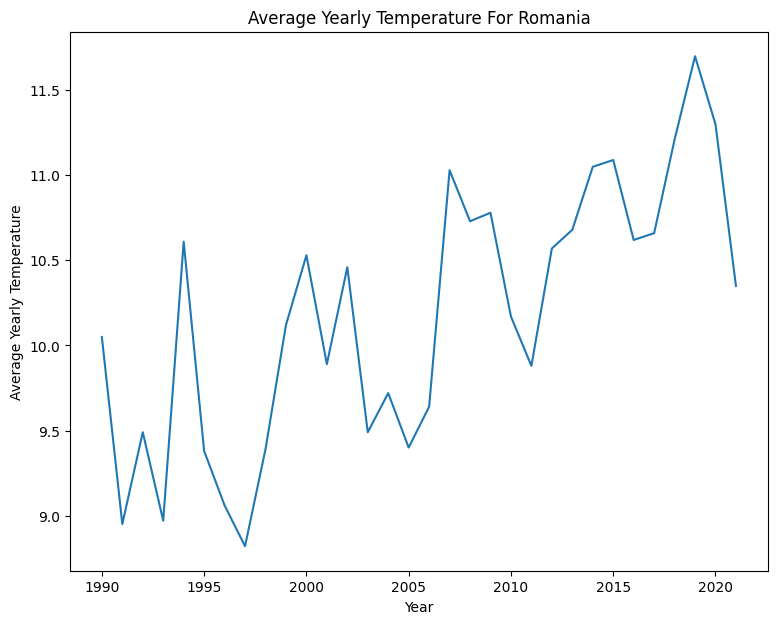

In [ ]:
plt.plot(average_yearly_temperatures['Year'], average_yearly_temperatures['ROU'])
plt.xlabel('Year')
plt.ylabel('Average Yearly Temperature')
plt.title('Average Yearly Temperature For Romania')
plt.show()

### Peak highs / lows + trendline

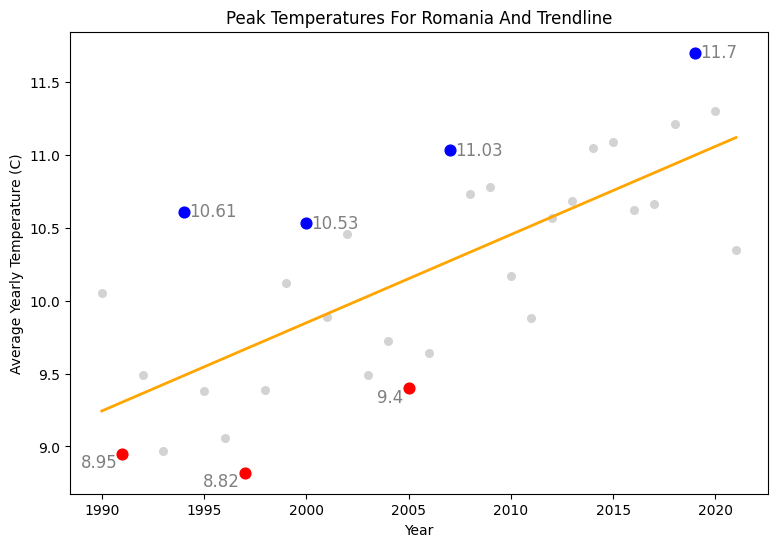

In [ ]:
matplotlib.rc('figure', figsize=(9, 6))

x = average_yearly_temperatures['Year']
y = average_yearly_temperatures['ROU']

peaks_low = signal.argrelmin(y.values, order=5)
peaks_high = signal.argrelmax(y.values, order=5)


coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
trendline_values = trendline(x)


# Plot the data points, peak lows, and peak highs
plt.scatter(x, y, label='Data', color='lightgray', s=30)
plt.scatter(x.iloc[peaks_low], y.iloc[peaks_low], color='red', label='Peak Lows', s=60)
plt.scatter(x.iloc[peaks_high], y.iloc[peaks_high], color='blue', label='Peak Highs', s=60)
plt.plot(x, trendline_values, color='orange', linewidth=2)


for i in peaks_low[0]:
    plt.text(x.iloc[i] - 0.25 , y.iloc[i], str(y.iloc[i]), ha='right', va='top', color='grey', fontsize=12)
for i in peaks_high[0]:
    plt.text(x.iloc[i] + 0.25, y.iloc[i], str(y.iloc[i]), ha='left', va='center', color='grey', fontsize=12)


plt.xlabel('Year')
plt.ylabel('Average Yearly Temperature (C)')
plt.title('Peak Temperatures For Romania And Trendline')
plt.show()

### Smoothing curve

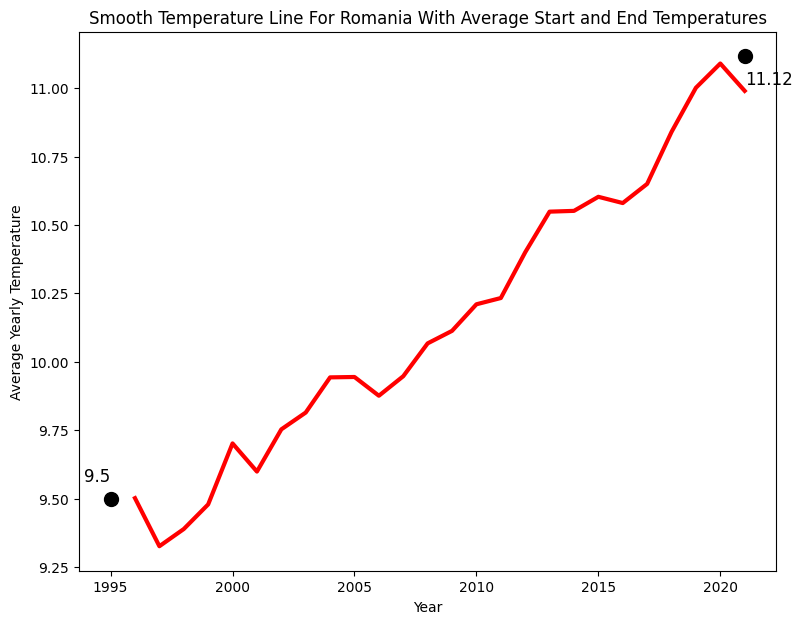

In [ ]:
matplotlib.rc('figure', figsize=(9, 7))

x = average_yearly_temperatures['Year']
y = average_yearly_temperatures['ROU']

window_size = 7
rolling_avg = y.rolling(window=window_size).mean()

first_three_avg = y.iloc[:3].mean()
last_three_avg = y.iloc[-3:].mean()

plt.plot(x, rolling_avg, color='red', linewidth=3, label=f'Smoothed (Window Size: {window_size})')

plt.scatter(x.iloc[[5, -1]], [first_three_avg, last_three_avg], color='black', s=100)
plt.text(x.iloc[5], first_three_avg + 0.05, str(round(first_three_avg, 2)), ha='right', va='bottom', color='black', fontsize=12)
plt.text(x.iloc[-1], last_three_avg - 0.05, str(round(last_three_avg, 2)), ha='left', va='top', color='black', fontsize=12)

plt.xlabel('Year')
plt.ylabel('Average Yearly Temperature')
plt.title('Smooth Temperature Line For Romania With Average Start and End Temperatures')
plt.show()


### Average temps for all countries

In [ ]:
column_drop_temporarily = ['Year']
average_yearly_temperatures['Avg'] = average_yearly_temperatures.drop(columns=column_drop_temporarily).mean(axis=1)

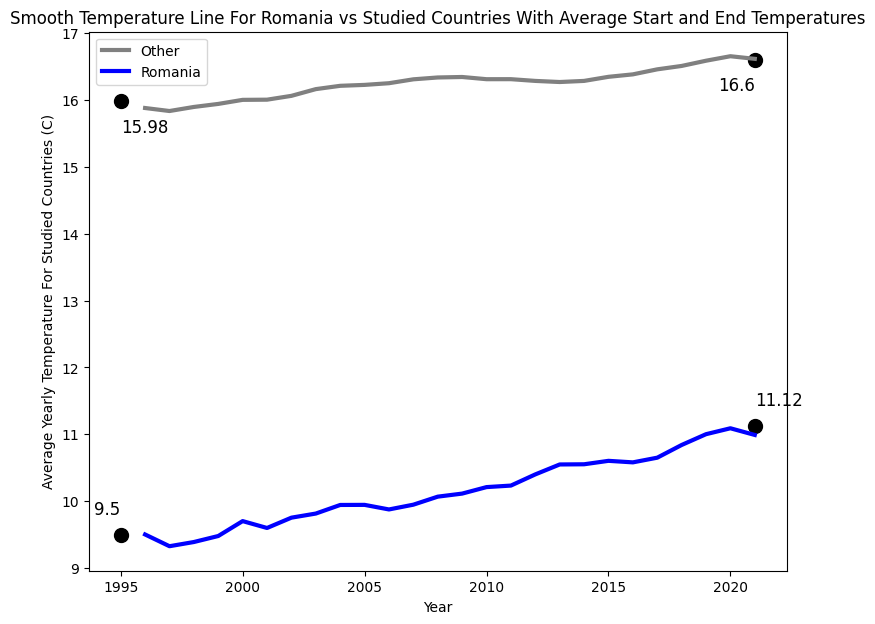

In [ ]:
matplotlib.rc('figure', figsize=(9, 7))

x = average_yearly_temperatures['Year']
y = average_yearly_temperatures['Avg']

window_size = 7
rolling_avg = y.rolling(window=window_size).mean()

first_three_avg = y.iloc[:3].mean()
last_three_avg = y.iloc[-3:].mean()

# Avearage
line_other = plt.plot(x, rolling_avg, color='grey', linewidth=3, label='Other')
plt.scatter(x.iloc[[5, -1]], [first_three_avg, last_three_avg], color='black', s=100)
plt.text(x.iloc[5], first_three_avg - 0.25, str(round(first_three_avg, 2)), ha='left', va='top', color='black', fontsize=12)
plt.text(x.iloc[-1], last_three_avg - 0.25, str(round(last_three_avg, 2)), ha='right', va='top', color='black', fontsize=12)

# Romania
y = average_yearly_temperatures['ROU']
rolling_avg = y.rolling(window=window_size).mean()
first_three_avg = y.iloc[:3].mean()
last_three_avg = y.iloc[-3:].mean()
line_ro = plt.plot(x, rolling_avg, color='blue', linewidth=3, label='Romania')
plt.scatter(x.iloc[[5, -1]], [first_three_avg, last_three_avg], color='black', s=100)
plt.text(x.iloc[5], first_three_avg + 0.25, str(round(first_three_avg, 2)), ha='right', va='bottom', color='black', fontsize=12)
plt.text(x.iloc[-1], last_three_avg + 0.25, str(round(last_three_avg, 2)), ha='left', va='bottom', color='black', fontsize=12)


plt.legend()
plt.xlabel('Year')
plt.ylabel('Average Yearly Temperature For Studied Countries (C)')
plt.title('Smooth Temperature Line For Romania vs Studied Countries With Average Start and End Temperatures')
plt.show()


### Romania temperature compared to Average temperatures

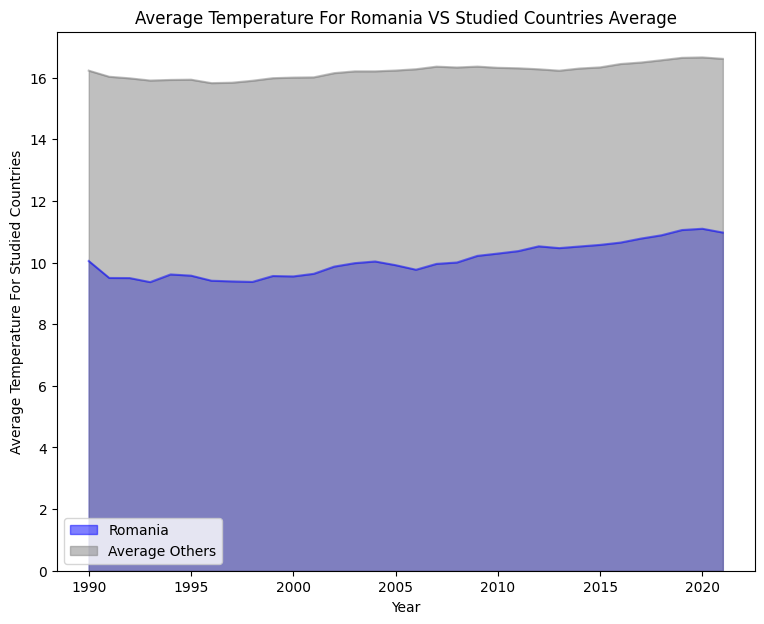

In [ ]:
colors = ['blue', 'grey']

average_temperatures_df = average_yearly_temperatures

average_temperatures_df['Romania'] = average_temperatures_df['ROU'].rolling(window=6, min_periods=1).mean()
average_temperatures_df['Average Others'] = average_temperatures_df['Avg'].rolling(window=6, min_periods=1).mean()

average_temperatures_df.plot(x='Year', y=['Romania', 'Average Others'], kind='area', stacked=False, color=colors)

plt.xlabel('Year')
plt.ylabel('Average Temperature For Studied Countries')
plt.title('Average Temperature For Romania VS Studied Countries Average')

plt.show()

## Precipitations study

### Average precipitations Romania

In [ ]:
average_yearly_precipitations = average_yearly_precipitations.apply(pd.to_numeric, errors='coerce')

### Average Yearly Precipitation For Romania

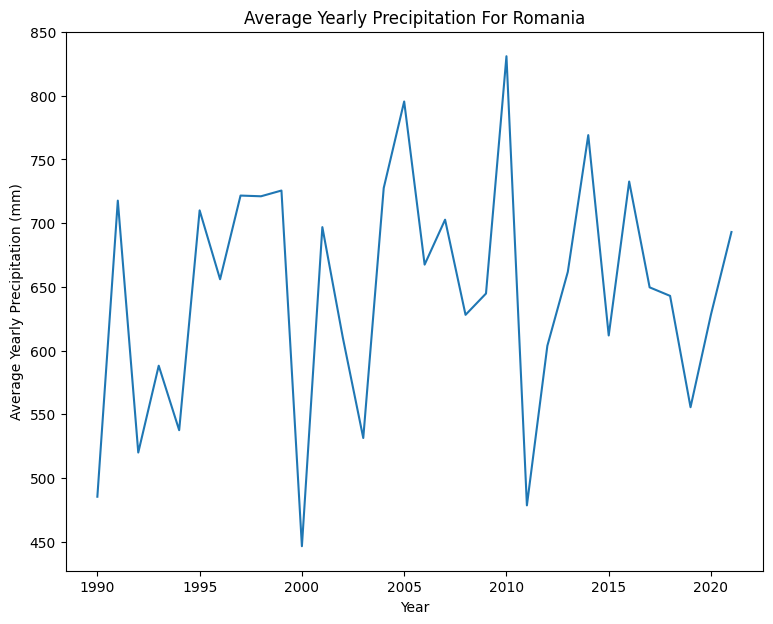

In [ ]:
plt.plot(average_yearly_precipitations['Year'], average_yearly_precipitations['ROU'])
plt.xlabel('Year')
plt.ylabel('Average Yearly Precipitation (mm)')
plt.title('Average Yearly Precipitation For Romania')
plt.show()

### Peak Precipitation For Romania And Trendline

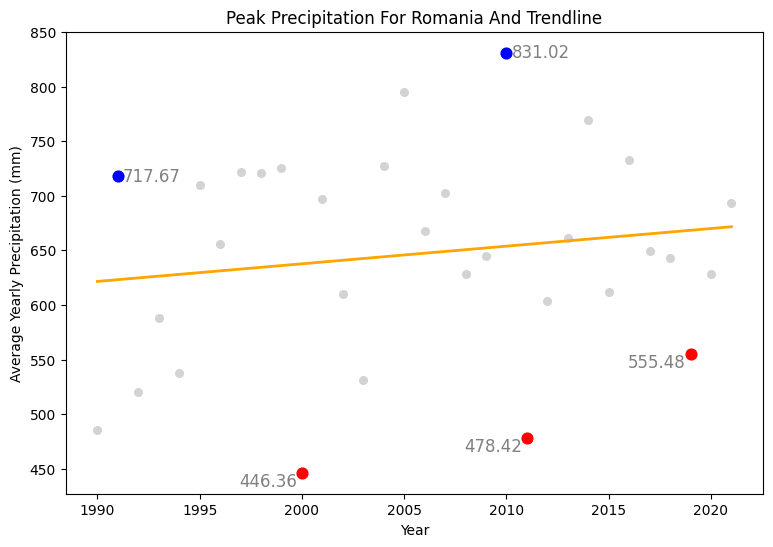

In [ ]:
matplotlib.rc('figure', figsize=(9, 6))

x = average_yearly_precipitations['Year']
y = average_yearly_precipitations['ROU']

peaks_low = signal.argrelmin(y.values, order=5)
peaks_high = signal.argrelmax(y.values, order=5)


coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
trendline_values = trendline(x)


# Plot the data points, peak lows, and peak highs
plt.scatter(x, y, label='Data', color='lightgray', s=30)
plt.scatter(x.iloc[peaks_low], y.iloc[peaks_low], color='red', label='Peak Lows', s=60)
plt.scatter(x.iloc[peaks_high], y.iloc[peaks_high], color='blue', label='Peak Highs', s=60)
plt.plot(x, trendline_values, color='orange', linewidth=2)


for i in peaks_low[0]:
    plt.text(x.iloc[i] - 0.25 , y.iloc[i], str(y.iloc[i]), ha='right', va='top', color='grey', fontsize=12)
for i in peaks_high[0]:
    plt.text(x.iloc[i] + 0.25, y.iloc[i], str(y.iloc[i]), ha='left', va='center', color='grey', fontsize=12)


plt.xlabel('Year')
plt.ylabel('Average Yearly Precipitation (mm)')
plt.title('Peak Precipitation For Romania And Trendline')
plt.show()

### Compute average for all countries for further study

In [ ]:
# Average all precipitations into 'Avg' column
average_precipitations_df = average_yearly_precipitations

column_drop_temporarily = ['Year']
average_precipitations_df['Avg'] = average_precipitations_df.drop(columns=column_drop_temporarily).mean(axis=1)

average_precipitations_df['precipitation_romania'] = average_yearly_precipitations['ROU'].rolling(window=6, min_periods=1).mean()
average_precipitations_df['precipitation_avg'] = average_yearly_precipitations['Avg'].rolling(window=6, min_periods=1).mean()

### Precipitation on average Romania vs other countries (bullet)

In [ ]:
import plotly.graph_objects as go

# https://plotly.com/python/bullet-charts/

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number+gauge+delta", value=average_precipitations_df['precipitation_romania'].values[-1],
    delta={'reference': average_precipitations_df['precipitation_avg'].values[-1]},
    domain={'x': [0.25, 1], 'y': [0.08, 0.25]},
    title={'text': "Precipitation for Romania (mm)"},
    gauge={
        'shape': "bullet",
        'axis': {'range': [None, average_precipitations_df['precipitation_avg'].max() + 100]},
        'threshold': {
            'line': {'color': "black", 'width': 2},
            'thickness': 0.75,
            'value': average_precipitations_df['precipitation_avg'].values[-1]},
        'steps': [
            {'range': [0, average_precipitations_df['precipitation_avg'].min()], 'color': "gray"},
            {'range': [average_precipitations_df['precipitation_avg'].min(), average_precipitations_df['precipitation_avg'].max()], 'color': "lightgray"}],
        'bar': {'color': "black"}}))


fig.add_trace(go.Indicator(
    mode="number+gauge+delta", value=average_yearly_precipitations['precipitation_avg'].values[-1],
    delta={'reference': average_yearly_precipitations['precipitation_avg'].values[-1]},
    domain={'x': [0.25, 1], 'y': [0.4, 0.6]},
    title={'text': "Average Precipitation (mm)"},
    gauge={
        'shape': "bullet",
        'axis': {'range': [None, average_yearly_precipitations['precipitation_avg'].max() + 100]},
        'threshold': {
            'line': {'color': "black", 'width': 2},
            'thickness': 0.75,
            'value': average_yearly_precipitations['precipitation_avg'].values[-1]},
        'steps': [
            {'range': [0, average_yearly_precipitations['precipitation_avg'].min()], 'color': "gray"},
            {'range': [average_yearly_precipitations['precipitation_avg'].min(), average_yearly_precipitations['precipitation_avg'].max()], 'color': "lightgray"}],
        'bar': {'color': "black"}}))

fig.update_layout(height=400, margin={'t': 0, 'b': 0, 'l': 0})
fig.update_layout(
    title={
        'text': "Precipitation for Romania vs Average Precipitation of Studied Countries 1990 - 2020",
        'x': 0.5,  # Set the title's position along the x-axis
        'y': 0.75,  # Set the title's position along the y-axis
        'xanchor': 'center',  # Set the x anchor to center
        'yanchor': 'top'  # Set the y anchor to the top
    }
)
fig.show()

## Emissions

In [ ]:
emissions_df = emissions_1990

In [ ]:
emissions_df = emissions_df.apply(pd.to_numeric, errors='coerce')

In [ ]:
emissions_df.head(5)

,Year,Australia,Botswana,Brazil,China,Democratic Republic of the Congo,Germany,India,Niger,Norway,Romania,United Kingdom,United States of America
31,1990,278.1542,2.7004,218.658,2484.8548,4.2490,1051.9791,577.9965,0.60178,35.097,173.4639,601.9451,5122.4962
32,1991,279.5285,2.6344,229.394,2606.0962,3.1326,1013.8241,615.3655,0.56879,33.535,141.9153,609.4127,5064.9872
33,1992,284.5253,2.7773,233.601,2730.7876,2.8082,965.5418,655.4476,0.52849,34.455,131.5099,593.8459,5175.2200
34,1993,288.8705,3.1950,244.306,2921.6510,2.6623,955.8199,677.2998,0.60184,36.000,122.2786,579.6125,5274.3626
35,1994,293.6966,3.0301,254.002,3100.0020,1.6982,939.4923,716.2686,0.57975,37.905,120.5423,574.0169,5365.5788


### Peak Emissions For Romania And Trendline

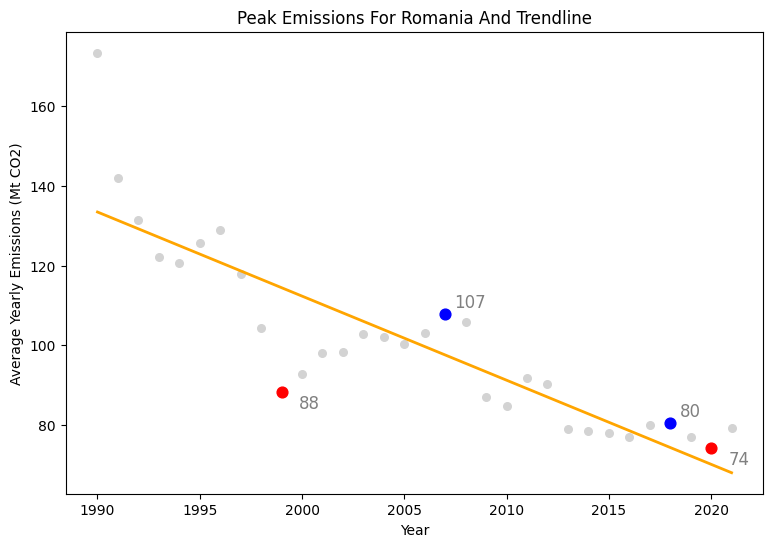

In [ ]:
matplotlib.rc('figure', figsize=(9, 6))

x = emissions_df['Year']
y = emissions_df['Romania']

peaks_low = signal.argrelmin(y.values, order=5)
peaks_high = signal.argrelmax(y.values, order=5)


coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
trendline_values = trendline(x)


# Plot the data points, peak lows, and peak highs
plt.scatter(x, y, label='Data', color='lightgray', s=30)
plt.scatter(x.iloc[peaks_low], y.iloc[peaks_low], color='red', label='Peak Lows', s=60)
plt.scatter(x.iloc[peaks_high], y.iloc[peaks_high], color='blue', label='Peak Highs', s=60)
plt.plot(x, trendline_values, color='orange', linewidth=2)


for i in peaks_low[0]:
    plt.text(x.iloc[i] + 0.85 , y.iloc[i] - 0.6, str(int(y.iloc[i])), ha='left', va='top', color='grey', fontsize=12)
for i in peaks_high[0]:
    plt.text(x.iloc[i] + 0.45, y.iloc[i] + 0.6, str(int(y.iloc[i])), ha='left', va='bottom', color='grey', fontsize=12)


plt.xlabel('Year')
plt.ylabel('Average Yearly Emissions (Mt CO2)')
plt.title('Peak Emissions For Romania And Trendline')
plt.show()

### Comparison with avearage for other countries

In [ ]:
average_emissions_df = emissions_df
average_emissions_df['Avg'] = average_emissions_df.drop(columns=['Year']).mean(axis=1)

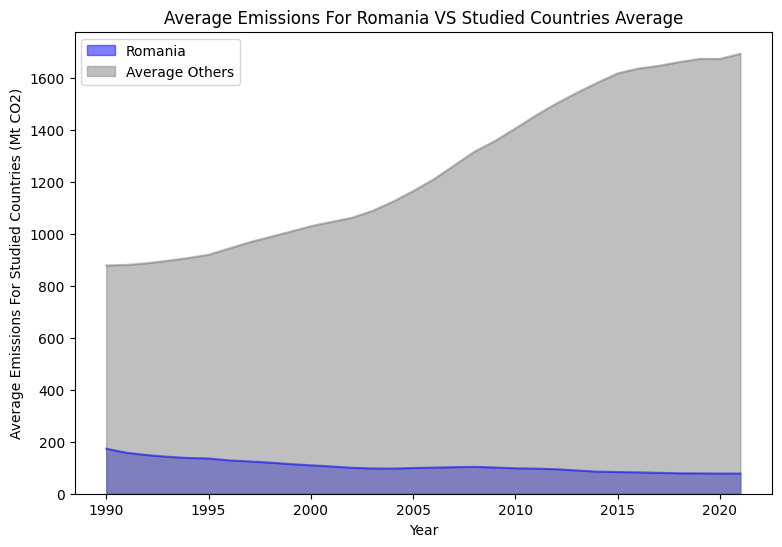

In [ ]:
colors = ['blue', 'grey']

average_emissions_df['Romania'] = average_emissions_df['Romania'].rolling(window=6, min_periods=1).mean()
average_emissions_df['Average Others'] = average_emissions_df['Avg'].rolling(window=6, min_periods=1).mean()

average_emissions_df.plot(x='Year', y=['Romania', 'Average Others'], kind='area', stacked=False, color=colors)

plt.xlabel('Year')
plt.ylabel('Average Emissions For Studied Countries (Mt CO2)')
plt.title('Average Emissions For Romania VS Studied Countries Average')

plt.show()

### Waffle Distribution for Emissions - 2020

In [ ]:
data = emissions_df[emissions_df['Year'] == 1990]
data = data.drop(columns=['Year', 'Avg', 'Average Others'], axis=1)

# Prepare the labels and values for the waffle chart
labels = data.columns.tolist()
values = data.values.flatten().tolist()


In [ ]:
total_emissions_per_year = sum(values)
percentages_per_country = [f'{i} ({str(round(j / total_emissions_per_year * 100, 2))}%)' for i,j in zip(labels, values)]

In [ ]:
country_colors

{'Australia': '#9B1D20',
 'Botswana': '#635D5C',
 'Brazil': '#3D2B3D',
 'China': '#CBEFB6',
 'Democratic Republic of Congo': '#E0AFA0',
 'Germany': '#587b7f',
 'India': '#0C4767',
 'Niger': '#14248A',
 'Norway': '#D4C2FC',
 'Romania': '#FFC857',
 'United Kingdom': '#C7EBF0',
 'United States': '#566E3D'}

In [ ]:
colors

['blue', 'grey']

In [ ]:
labels

['Australia',
 'Botswana',
 'Brazil',
 'China',
 'Democratic Republic of the Congo',
 'Germany',
 'India',
 'Niger',
 'Norway',
 'Romania',
 'United Kingdom',
 'United States of America']

In [ ]:
values

[278.1542,
 2.7004,
 218.658,
 2484.8548,
 4.249,
 1051.9791,
 577.9965,
 0.60178,
 35.097,
 173.4639,
 601.9451,
 5122.4962]

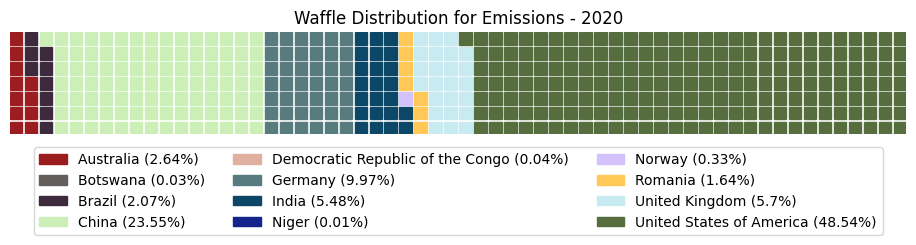

In [ ]:
# Create the waffle chart
colors = list(country_colors.values())

fig = plt.figure(
    FigureClass=Waffle,
    rows=7,
    columns = 60,
    values=values,
    colors=colors,
    labels=percentages_per_country,
    figsize=(10, 10),  # Set the size of the chart
    legend={'loc':'lower center',
            'bbox_to_anchor': (0.5, -1.05),
            'ncol':3,
            'fontsize':10}
)

# Customize the chart
plt.title("Waffle Distribution for Emissions - 2020")
#plt.tight_layout()

# Show the waffle chart
plt.show()

### Waffle Distribution for Total Emissions: 1990 - 2020


In [ ]:
data = emissions_df
data = data.drop(columns=['Year', 'Avg', 'Average Others'], axis=1)
column_names = data.columns
data = data[column_names].sum()
total = data.sum()

In [ ]:
labels = list(data.keys())
values = list(data.values)

In [ ]:
percentages_per_country = [f'{i} ({str(round(j / total * 100, 2))}%)' for i,j in zip(labels, values)]

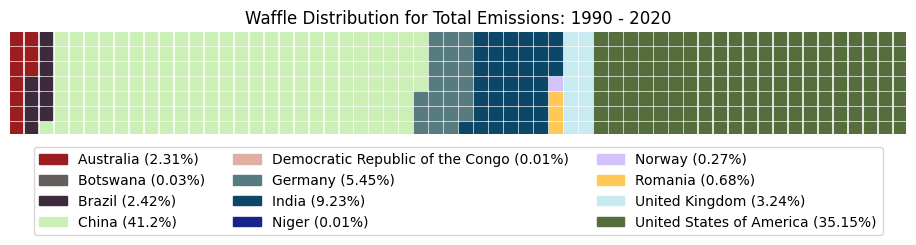

In [ ]:
colors = list(country_colors.values())

fig = plt.figure(
    FigureClass=Waffle,
    rows=7,
    columns = 60,
    values=values,
    colors=colors,
    labels=percentages_per_country,
    figsize=(10, 10),  # Set the size of the chart
    legend={'loc':'lower center',
            'bbox_to_anchor': (0.5, -1.05),
            'ncol':3,
            'fontsize':10},
    starting_location='NW'
)

# Customize the chart
plt.title("Waffle Distribution for Total Emissions: 1990 - 2020")
#plt.tight_layout()

# Show the waffle chart
plt.show()

### Emissions per capita 2020

In [ ]:
emissions_for_merge = emissions_df.drop(columns=['Avg', 'Average Others'])
emissions_for_merge = emissions_for_merge.rename(columns={'United States of America': 'United States'})

population_for_merge = population_df
population_for_merge.columns.name = None
population_for_merge = population_for_merge.rename(columns={'Democratic Republic of Congo': 'Democratic Republic of the Congo'})


emissions_for_merge = emissions_for_merge[sorted(emissions_for_merge.columns)]
population_for_merge = population_for_merge[sorted(population_for_merge.columns)]

In [ ]:
emissions_df = emissions_for_merge
population_df = population_for_merge

In [ ]:
emissions_temp = emissions_df
population_temp = population_df

In [ ]:
population_temp.head(5)

,Australia,Botswana,Brazil,China,Democratic Republic of the Congo,Germany,India,Niger,Norway,Romania,United Kingdom,United States,Year
0,17065128,1341474,150706446,1135185000,35987541,79433029,870452165,8370648,4241473,23201835,57247586,249623000,1990
1,17284036,1380584,153336445,1150780000,37194812,80013896,888941756,8634640,4261732,23001155,57424897,252981000,1991
2,17478635,1420695,155900790,1164970000,38332302,80624598,907574049,8907644,4286401,22794284,57580402,256514000,1992
3,17634808,1462262,158440875,1178440000,39580844,81156363,926351297,9193078,4311991,22763280,57718614,259919000,1993
4,17805468,1503544,160980472,1191835000,41511985,81438348,945261958,9493324,4336613,22730211,57865745,263126000,1994


In [ ]:
emissions_temp.head(5)

,Australia,Botswana,Brazil,China,Democratic Republic of the Congo,Germany,India,Niger,Norway,Romania,United Kingdom,United States,Year
31,278.1542,2.7004,218.658,2484.8548,4.2490,1051.9791,577.9965,0.60178,35.097,173.463900,601.9451,5122.4962,1990
32,279.5285,2.6344,229.394,2606.0962,3.1326,1013.8241,615.3655,0.56879,33.535,157.689600,609.4127,5064.9872,1991
33,284.5253,2.7773,233.601,2730.7876,2.8082,965.5418,655.4476,0.52849,34.455,148.963033,593.8459,5175.2200,1992
34,288.8705,3.1950,244.306,2921.6510,2.6623,955.8199,677.2998,0.60184,36.000,142.291925,579.6125,5274.3626,1993
35,293.6966,3.0301,254.002,3100.0020,1.6982,939.4923,716.2686,0.57975,37.905,137.942000,574.0169,5365.5788,1994


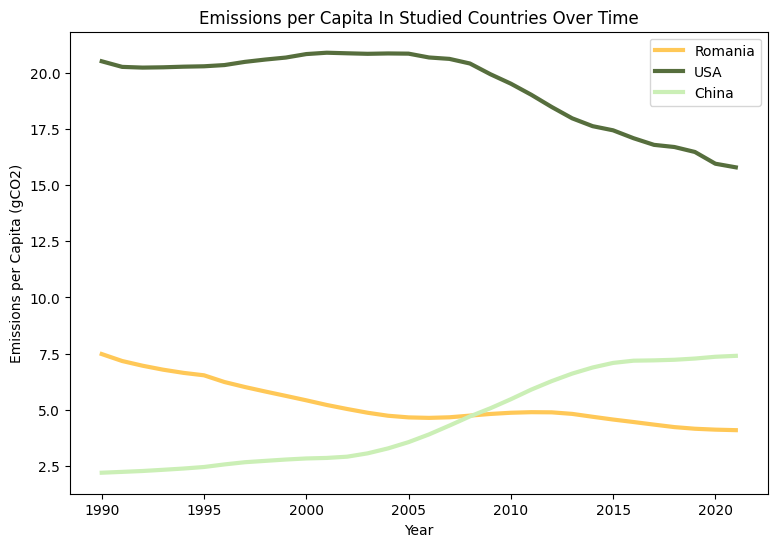

In [ ]:
# a dat domnu amin -> index must correspond when doing operations on DFs
emissions_temp.reset_index(drop=True, inplace=True)
population_temp.reset_index(drop=True, inplace=True)

emissions_temp['emissions_romania'] = (emissions_temp['Romania'] * 1000 * 1000) / population_temp['Romania'].astype(int) #tonne -> kg -> g
emissions_temp['Average Romania'] = emissions_temp['emissions_romania'].rolling(window=6, min_periods=1).mean()
plt.plot(emissions_temp['Year'], emissions_temp['Average Romania'], label='Romania', color=country_colors['Romania'], linewidth=3)

emissions_temp['emissions_usa'] = (emissions_temp['United States'] * 1000 * 1000) / population_temp['United States'].astype(int) #tonne -> kg -> g
emissions_temp['Average USA'] = emissions_temp['emissions_usa'].rolling(window=6, min_periods=1).mean()
plt.plot(emissions_temp['Year'], emissions_temp['Average USA'], label='USA', color=country_colors['United States'], linewidth=3)


emissions_temp['emissions_china'] = (emissions_temp['China'] * 1000 * 1000) / population_temp['China'].astype(int) #tonne -> kg -> g
emissions_temp['Average China'] = emissions_temp['emissions_china'].rolling(window=6, min_periods=1).mean()
plt.plot(emissions_temp['Year'], emissions_temp['Average China'], label='China', color=country_colors['China'], linewidth=3)


plt.xlabel('Year')
plt.ylabel('Emissions per Capita (gCO2)')
plt.title('Emissions per Capita In Studied Countries Over Time')
plt.legend()
plt.show()

### Power plot: emissions influencing temperature and precipitations?

### it's important to note that correlation does not necessarily imply causation: low emissions paired with high temperatures / precipitations

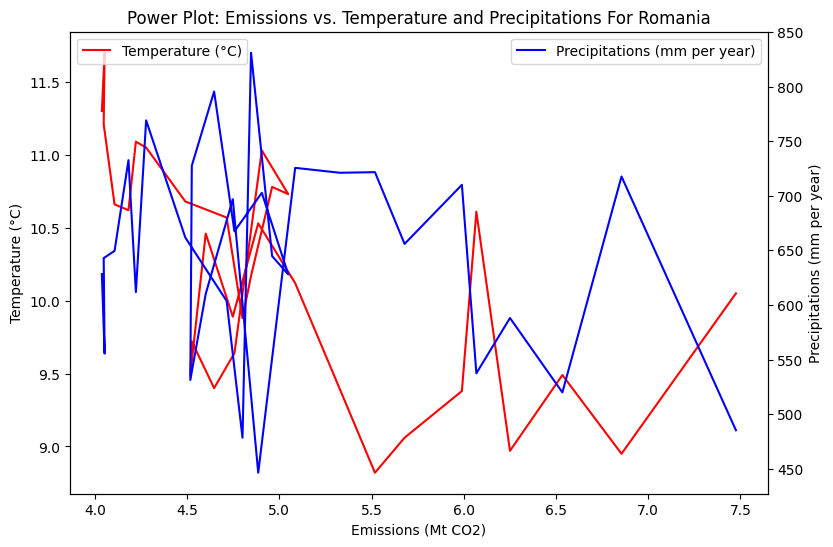

In [ ]:
emissions_temperature_precipitations_df = pd.DataFrame()
emissions_temperature_precipitations_df['temperatures_romania'] = average_yearly_temperatures['ROU'] # measured in C
emissions_temperature_precipitations_df['precipitations_romania'] = average_yearly_precipitations['ROU'] # measured in mm per year

emissions_temp_index_fixed = emissions_temp
emissions_temp_index_fixed = emissions_temp_index_fixed.reset_index()
emissions_temperature_precipitations_df = emissions_temperature_precipitations_df.reset_index()

emissions_temperature_precipitations_df['emissions_romania'] = emissions_temp_index_fixed['emissions_romania']#['Average Romania'] # measured in Mt CO2
emissions_temperature_precipitations_df['Year'] = emissions_temp_index_fixed['Year']

#plt.plot(emissions_temperature_precipitations_df['emissions_romania'], emissions_temperature_precipitations_df['temperatures_romania'], label='Temperature (°C)', color='red')
#plt.plot(emissions_temperature_precipitations_df['emissions_romania'], emissions_temperature_precipitations_df['precipitations_romania'], label='Precipitations (mm per year)', color='blue')

fig, ax1 = plt.subplots()
ax1.plot(emissions_temperature_precipitations_df['emissions_romania'], emissions_temperature_precipitations_df['temperatures_romania'], label='Temperature (°C)', color='red')
ax1.set_xlabel('Emissions (Mt CO2)')
ax1.set_ylabel('Temperature (°C)')

ax2 = ax1.twinx()
ax2.plot(emissions_temperature_precipitations_df['emissions_romania'], emissions_temperature_precipitations_df['precipitations_romania'], label='Precipitations (mm per year)', color='blue')
ax2.set_ylabel('Precipitations (mm per year)')

ax1.yaxis.set_label_position('left')
ax2.yaxis.set_label_position('right')

plt.title('Power Plot: Emissions vs. Temperature and Precipitations For Romania')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

## Temperatures displayed on top of Romania (Folium)

In [ ]:
!pip install folium geopandas

In [ ]:
import geopandas as gpd
import urllib
import folium
import requests
from folium.plugins import FloatImage

In [ ]:
def get_temperatures_by_county(given_year):
  temperatures_df = temperatures['ROU']

  temperatures_df.rename(columns={temperatures_df.columns[0] : 'Year'}, inplace=True)
  temperatures_df['Year'] = temperatures_df['Year'].astype(int)

  temperatures_for_given_year = temperatures_df[temperatures_df['Year'] == given_year]
  temp_df = temperatures_for_given_year.drop(columns=['Year', 'Romania'])

  transposed_df = temp_df.transpose()
  transposed_df = transposed_df.reset_index()
  transposed_df.columns= ['County', 'Temperature']

  return transposed_df

def get_clean_temperature_for_county(temperatures_df):
  temperatures_numeric = temperatures_df
  temperatures_numeric['Temperature'] = pd.to_numeric(temperatures_numeric['Temperature'], errors='coerce')
  temperatures_numeric = temperatures_numeric.dropna(subset=['Temperature'])

  experiment_df = temperatures_numeric

  experiment_df['County'][5] = 'Bistrita-Nasaud'
  experiment_df['County'][9] = 'Bucuresti'
  experiment_df['County'][12] = 'Caras-Severin'
  experiment_df['County'][16] = 'Dambovita'
  experiment_df['County'][25] = 'Maramureș'
  experiment_df['County'][39] = 'Vâlcea'

  return experiment_df

def do_folium(some_df):
  geojson_url = 'https://raw.githubusercontent.com/GabrielRondelli/geojson/main/romania-counties.geojson'
  response = requests.get(geojson_url)
  geojson_data = response.json()

  m = folium.Map(location=[46.0, 25.0], zoom_start=6)

  folium.Choropleth(
      geo_data=geojson_data,
      name='Temperature',
      data=some_df,
      columns=['County', 'Temperature'],
      key_on='feature.properties.NAME_1',
      fill_color='YlOrRd',
      fill_opacity=0.75,
      line_opacity=0.8,
      legend_name='Temperature (°C)',
      legend_scale=10,
      legend_font=12,
      Highlight= True,
      line_color = "#0000",
      show=False,
      overlay=True,
  ).add_to(m)

  return m

In [ ]:
temperatures_df_2020 = get_temperatures_by_county(2020)
temperatures_df_1990 = get_temperatures_by_county(1990)

temperatures_df_2020 = get_clean_temperature_for_county(temperatures_df_2020)
temperatures_df_1990 = get_clean_temperature_for_county(temperatures_df_1990)

In [ ]:
map_1990 = do_folium(temperatures_df_1990)
map_2020 = do_folium(temperatures_df_2020)

In [ ]:
map_1990

In [ ]:
map_2020

## Burned area

Romania has a total of 238.397 square Km

In [ ]:
burned_area_by_year = burned_area_by_year_or_season['Romania']['Year']
burned_area_by_season = burned_area_by_year_or_season['Romania']['Season']

### Total Burned Area by Year for Romania

<ipython-input-16-4f1a79609161>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Improve spacing


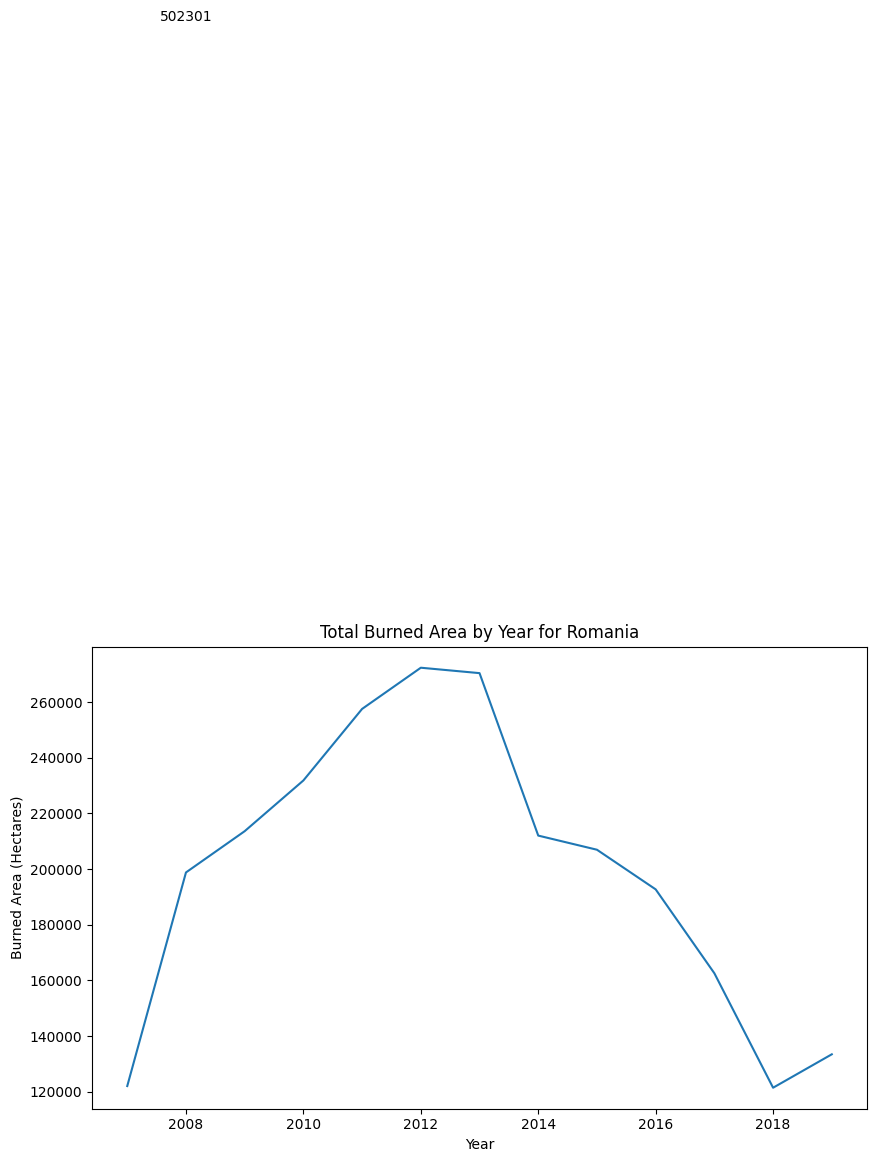

In [ ]:

plt.figure(figsize=(10, 6))

plt.plot(burned_area_by_year['Year'], burned_area_by_year['Burned Area'].rolling(window=6).mean)
plt.xlabel('Year')
plt.ylabel('Burned Area (Hectares)')
plt.title('Total Burned Area by Year for Romania')

max_burned = burned_area_by_year['Burned Area'].max()
for i, value in enumerate(burned_area_by_year['Burned Area']):
  if value == max_burned:
    plt.text(burned_area_by_year['Year'].iloc[i], value + 2500, str(value), ha='center')

plt.tight_layout()  # Improve spacing
plt.show()

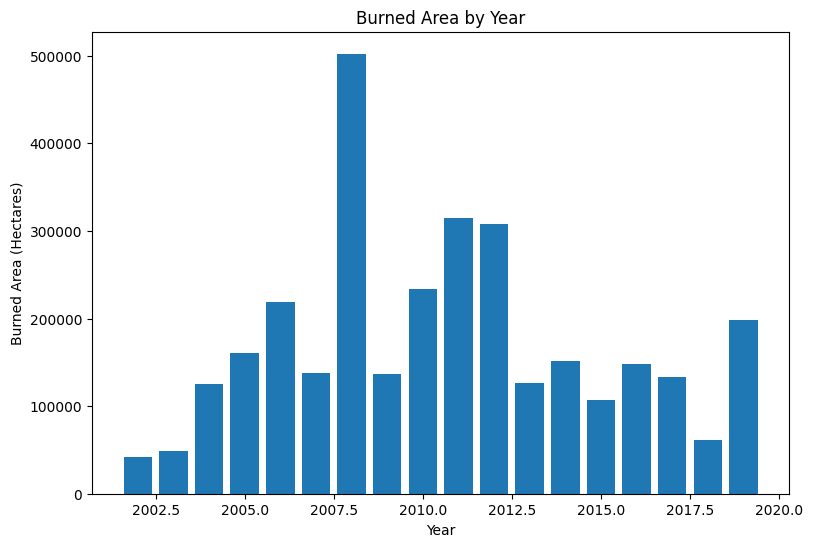

In [ ]:
plt.bar(burned_area_by_year['Year'], burned_area_by_year['Burned Area'])
plt.xlabel('Year')
plt.ylabel('Burned Area (Hectares)')
plt.title('Burned Area by Year')
plt.show()

### Burned Area by Year and Season in Hectares

<ipython-input-59-32f5eb1b19e1>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



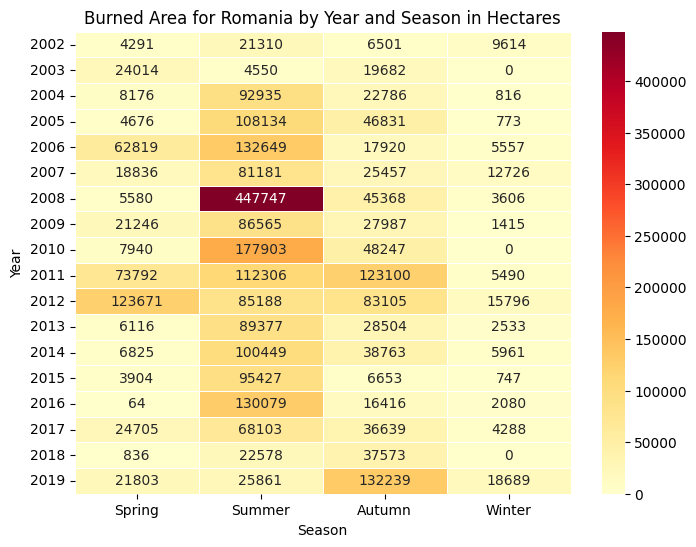

In [ ]:
season_order = ["Spring", "Summer", "Autumn", "Winter"]
burned_area_by_season["Season"] = pd.Categorical(burned_area_by_season["Season"], categories=season_order, ordered=True)

heatmap_data = burned_area_by_season.pivot("Year", "Season", "Burned Area")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt="d", linewidths=0.5, cbar=True)
plt.title("Burned Area for Romania by Year and Season in Hectares")
plt.xlabel("Season")
plt.ylabel("Year")
plt.show()

### Burned Area for Romania by Season 2002 - 2019

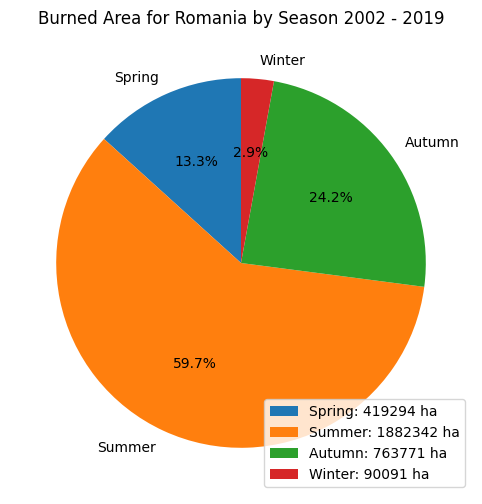

In [ ]:
season_totals = burned_area_by_season.groupby('Season')['Burned Area'].sum()

labels = season_totals.index
burned_areas = season_totals.values

plt.pie(burned_areas, labels=labels, autopct='%1.1f%%', startangle=90)

legend_labels = [f'{label}: {area} ha' for label, area in zip(labels, burned_areas)]

plt.title('Burned Area for Romania by Season 2002 - 2019')
plt.legend(legend_labels, loc='lower right')
plt.show()

## Forrest change

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
relevant_forrest_change

,Entity,Code,Year,Annual net change in forest area
12,Australia,AUS,1990,-206810.0
13,Australia,AUS,2000,-226800.0
14,Australia,AUS,2010,709680.0
46,Brazil,BRA,1990,-3780940.0
47,Brazil,BRA,2000,-3950790.0
48,Brazil,BRA,2010,-1539180.0
49,Brazil,BRA,2015,-1453040.0
81,China,CHN,1990,1986000.0
82,China,CHN,2000,2360980.0
83,China,CHN,2010,1936770.0


### Forest Change (Reforestation vs. Deforestation) in Romania

<ipython-input-63-44a9ffc148e3>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-44a9ffc148e3>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-44a9ffc148e3>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-44a9ffc

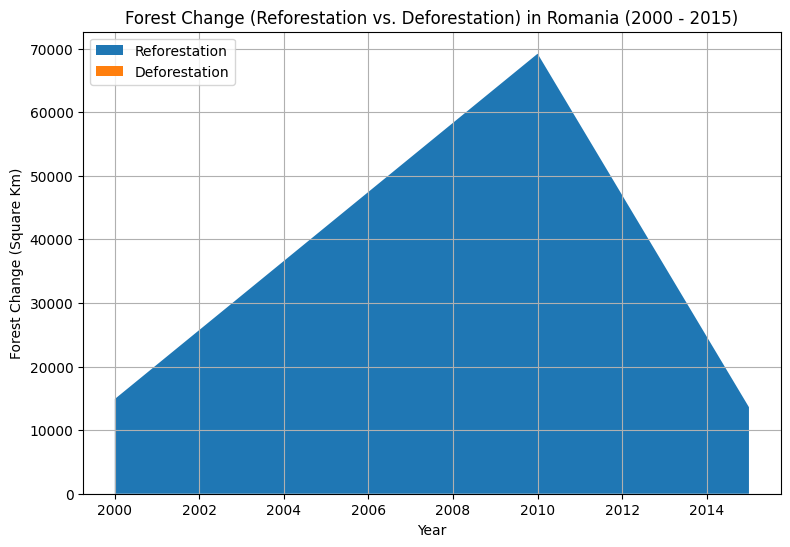

In [ ]:
romania_data = relevant_forrest_change[relevant_forrest_change['Entity'] == 'Romania']

romania_data['Positive Change'] = romania_data['Annual net change in forest area'].clip(lower=0)
romania_data['Negative Change'] = romania_data['Annual net change in forest area'].clip(upper=0).abs()

romania_data['Positive Cumulative'] = romania_data.groupby('Year')['Positive Change'].cumsum()
romania_data['Negative Cumulative'] = romania_data.groupby('Year')['Negative Change'].cumsum()

plt.stackplot(romania_data['Year'], romania_data['Positive Cumulative'], romania_data['Negative Cumulative'], labels=['Reforestation', 'Deforestation'])

plt.xlabel('Year')
plt.ylabel('Forest Change (Square Km)')
plt.title('Forest Change (Reforestation vs. Deforestation) in Romania (2000 - 2015)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Forest Change For Studied Countries (Reforestation vs. Deforestation)

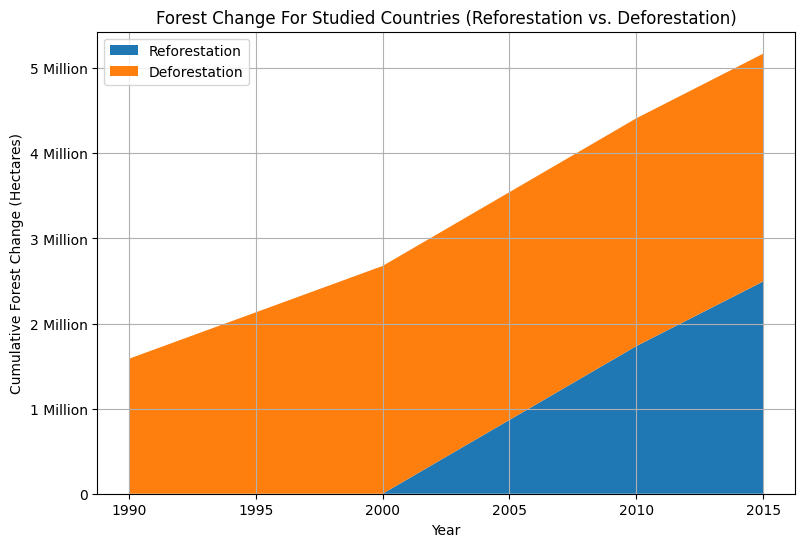

In [ ]:
grouped_data = relevant_forrest_change.groupby('Year')['Annual net change in forest area'].sum().reset_index()
grouped_data['Positive Change'] = grouped_data['Annual net change in forest area'].clip(lower=0)
grouped_data['Negative Change'] = grouped_data['Annual net change in forest area'].clip(upper=0).abs()
grouped_data['Positive Cumulative'] = grouped_data['Positive Change'].cumsum()
grouped_data['Negative Cumulative'] = grouped_data['Negative Change'].cumsum()

plt.stackplot(grouped_data['Year'], grouped_data['Positive Cumulative'], grouped_data['Negative Cumulative'], labels=['Reforestation', 'Deforestation'])

plt.xlabel('Year')
plt.ylabel('Cumulative Forest Change (Hectares)')
plt.title('Forest Change For Studied Countries (Reforestation vs. Deforestation)')
plt.legend(loc='upper left')
plt.grid(True)

def format_ticks(x, pos):
    if x >= 1_000_000:
        return f'{x / 1_000_000:.0f} Million'
    return int(x)
formatter = ticker.FuncFormatter(format_ticks)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()